# Setup

In [23]:
import os 
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Imports from eo-learn and sentinelhub-py
from sentinelhub import CRS, BBox, SHConfig, DataCollection

from eolearn.core import (FeatureType,
                          EOPatch, 
                          EOTask, 
                          LinearWorkflow, 
                          EOExecutor, 
                          LoadTask,
                          SaveTask)
from eolearn.io import GeoDBVectorImportTask, SentinelHubInputTask

# Module for GeoDB
from xcube_geodb.core.geodb import GeoDBClient

# Read Data

The building blocks of eo-learn are EOPatch, EOTask and EOWorkflow objects.

* An EOPatch instance is uniquely defined by coordinates of a bounding box and the time-interval the stored data refers to. 
* Any operation on EOPatch instances is performed by EOTask instances


In [4]:
path = "/home/frauke/ai4eo-challenge/data"
eopatch153 = EOPatch.load(os.path.join(path, 'eopatch-153'))

The data is now stored in an EOPatch, where each raster feature is stored as a numpy array, vector data stored as a geopandas dataframe, while dates as datetime objects.

In [5]:
eopatch153

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(24, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(24, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(24, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(24, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(2000, 2000, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['id', 'created_at', 'modified_at', 'geometry', 'label'], length=7143, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seco

# Access EOPatch Content

In [15]:
print(len(eopatch153.timestamp))
eopatch153.timestamp

24


[datetime.datetime(2019, 3, 2, 10, 19, 44, tzinfo=tzlocal()),
 datetime.datetime(2019, 3, 12, 10, 16, 22, tzinfo=tzlocal()),
 datetime.datetime(2019, 3, 22, 10, 24, 22, tzinfo=tzlocal()),
 datetime.datetime(2019, 4, 1, 10, 9, 59, tzinfo=tzlocal()),
 datetime.datetime(2019, 4, 16, 10, 13, 36, tzinfo=tzlocal()),
 datetime.datetime(2019, 4, 21, 10, 22, 7, tzinfo=tzlocal()),
 datetime.datetime(2019, 5, 1, 10, 8, 10, tzinfo=tzlocal()),
 datetime.datetime(2019, 5, 31, 10, 8, 9, tzinfo=tzlocal()),
 datetime.datetime(2019, 6, 5, 10, 8, 14, tzinfo=tzlocal()),
 datetime.datetime(2019, 6, 10, 10, 8, 9, tzinfo=tzlocal()),
 datetime.datetime(2019, 6, 20, 10, 8, 10, tzinfo=tzlocal()),
 datetime.datetime(2019, 6, 25, 10, 8, 15, tzinfo=tzlocal()),
 datetime.datetime(2019, 6, 30, 10, 8, 11, tzinfo=tzlocal()),
 datetime.datetime(2019, 7, 5, 10, 8, 15, tzinfo=tzlocal()),
 datetime.datetime(2019, 7, 10, 10, 8, 11, tzinfo=tzlocal()),
 datetime.datetime(2019, 7, 20, 10, 8, 11, tzinfo=tzlocal()),
 datetime.d

In [9]:
eopatch153.mask['CLM'].shape

(24, 500, 500, 1)

In [14]:
eopatch153.data['BANDS'].shape
#eopatch153.data['BANDS'][5][..., [3, 2, 1]]

(24, 500, 500, 12)

# Plots

Code copied from starter notebook

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


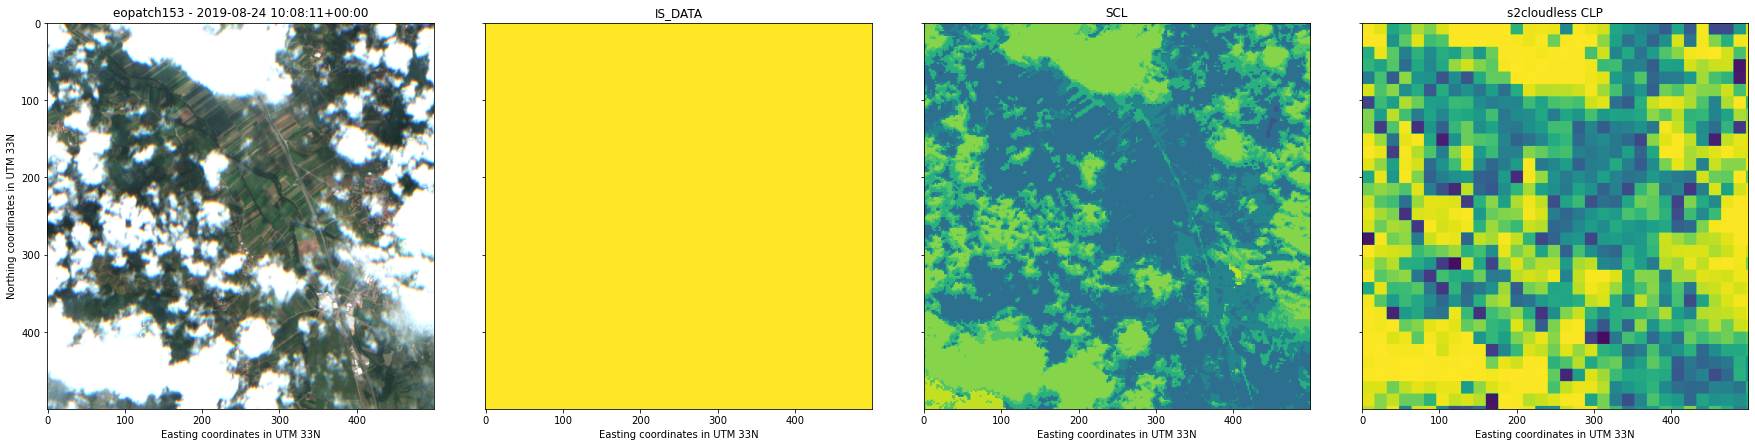

In [35]:
# choose one time index from [0..23] to visualise
tidx = 22

vis_factor = 3.5

norm_factor = eopatch153.scalar['NORM_FACTORS'][tidx]

fig, axs = plt.subplots(figsize=(25, 6), ncols=4, sharey=True)

axs[0].imshow(vis_factor * norm_factor * eopatch153.data['BANDS'][tidx][..., [3, 2, 1]])#,extent=get_extent(eopatch153))
axs[0].set_title(f'eopatch153 - {eopatch153.timestamp[tidx]}')
axs[0].set_ylabel(f'Northing coordinates in UTM 33N')
axs[0].set_xlabel(f'Easting coordinates in UTM 33N')

axs[1].imshow(eopatch153.mask['IS_DATA'][tidx].squeeze(), 
              vmin=0, vmax=1)#, extent=get_extent(eopatch153))
axs[1].set_title('IS_DATA')
axs[1].set_xlabel(f'Easting coordinates in UTM 33N')

axs[2].imshow(eopatch153.mask['SCL'][tidx].squeeze(), 
              #extent=get_extent(eopatch153), 
              #cmap=ListedColormap([np.array(v) for v in scl_dict.values()]),
              vmin=0, vmax=11)
axs[2].set_title('SCL')
axs[2].set_xlabel(f'Easting coordinates in UTM 33N')

axs[3].imshow(eopatch153.data['CLP'][tidx].squeeze()/255, vmin=0, vmax=1)#, extent=get_extent(eopatch153))
axs[3].set_title('s2cloudless CLP')
axs[3].set_xlabel(f'Easting coordinates in UTM 33N')

plt.tight_layout();

In [16]:
scl_dict =  {
    0: [0, 0, 0],  # no data
    1: [1, 0, 0.016],  # saturated / defected
    2: [0.525, 0.525, 0.525],  # dark area pixels
    3: [0.467, 0.298, 0.043],  # cloud shadows
    4: [0.063, 0.827, 0.176],  # vegetation
    5: [1, 1, 0.325],  # bare soils
    6: [0, 0, 1],  # water
    7: [0.506, 0.506, 0.506],  # clouds low probability / unclassified 
    8: [0.753, 0.753, 0.753],  # clouds medium probability
    9: [0.949, 0.949, 0.949],  # clouds high probability
    10: [0.733, 0.773, 0.925],  # cirrus
    11: [0.325, 1, 0.980]  # ice / snow
}

The information in the provided masks can be used to mask out invalid frames containing clouds/snow/fog. Below is an example using `IS_DATA` and `CLM` mask to find the percentage of valid data in the 6-months period.

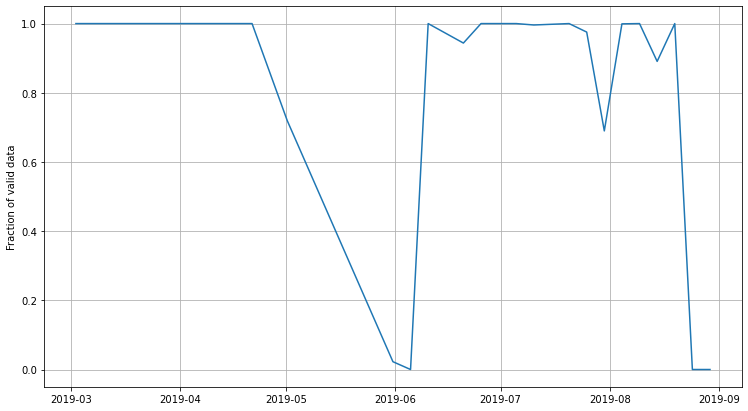

In [20]:
valid_data = np.mean(eopatch153.mask['IS_DATA'] & ~eopatch153.mask['CLM'], 
                     axis=(1,2,3)) 

fig, ax = plt.subplots(figsize=(12.5, 7))
ax.plot(eopatch153.timestamp, valid_data)
ax.set_ylabel('Fraction of valid data')
ax.grid();

Number of frames for this EOPatch with a fraction of valid data greater than 90%. The `SCL` mask and `CLP` masks can be similarly used to estimate data validity fractions.

In [21]:
np.sum(valid_data > .9)

17